# Maximisation couple moyen (non-linéaire)

Ce notebook propose d'optimiser le rotor d'une machine synchro-réluctante sans aimant à une paire de pôle en vue de maximiser le couple moyen.
Dans ce cas particulier, le couple moyen est directement relié à la différence de perméance magnétique du rotor dans l'axe direct d et l'axe en quadrature q.

Le problème étudié est donc la maximisation de cette différence de perméance via la différence de compliance magnétique. Il est possible de démontrer que ce problème est mal posé.

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry
#from netgen.geom2d import unit_square
from copy import copy
from numpy.random import randint
import numpy as np
import matplotlib.pyplot as plt
from ngsolve.solvers import Newton

importing NGSolve-6.2.2105-9-g5a835126f


## 1) Définition du maillage

La première étape consiste à définir une géométrie (disque), ainsi que la finesse de maillage associée.

In [ ]:
geo = SplineGeometry()

R = 1;
h = R/20; # ne pas prendre moins de R/50

pnts = [(R,-R),(-R,-R),(-R,R),(R,R)]

p = [geo.AppendPoint(*pnt) for pnt in pnts]


geo.Append(["line",0,1],leftdomain=0,rightdomain=1,bc="bottom")
geo.Append(["line",1,2],leftdomain=0,rightdomain=1,bc="left")
geo.Append(["line",2,3],leftdomain=0,rightdomain=1,bc="up")
geo.Append(["line",3,0],leftdomain=0,rightdomain=1,bc="right")

geo.SetMaterial(1, "in")

ngmesh = geo.GenerateMesh(maxh=h)
mesh = Mesh(ngmesh)
Draw (mesh)

## 2) Définition des problèmes éléments finis

L'objectif est ici de maximiser la différence de compliance magnétique pour deux chargement distincts. On va résoudre le problème magnétostatique dual ; pour cela, remarquons qu'en l'absence de termes sources:

$$ \overrightarrow{\text{rot}} ~ \overrightarrow{h} = 0 $$

On pose donc $\phi$ un potentiel scalaire tel que $\overrightarrow{h} = \overrightarrow{\text{grad}} ~ \phi$, qui vérifie donc dans $\Omega$:
$$ \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 $$

$\phi$ est un champ scalaire qu'on va supposer appartenant à $H^1$. Les conditions aux bords sont de Neumann. La solution est unique à une constante près. Les deux problèmes à résoudre s'écrivent donc :

$$\left \{
\begin{array}{l}
     \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 \\
     \frac{\partial \phi}{\partial n} = \Phi ~ \text{sur} ~ \Gamma_1 \bigcup \Gamma_2 \\
     \frac{\partial \phi}{\partial n} = - \Phi ~ \text{sur} ~ \Gamma_3 \bigcup \Gamma_4 
\end{array}
\right. $$

$$\left \{
\begin{array}{l}
     \text{div}( \mu ~\overrightarrow{\text{grad}} ~ \phi ) = 0 \\
     \frac{\partial \phi}{\partial n} = \Phi ~ \text{sur} ~ \Gamma_2 \bigcup \Gamma_3 \\
     \frac{\partial \phi}{\partial n} = - \Phi ~ \text{sur} ~ \Gamma_1 \bigcup \Gamma_4 
\end{array}
\right. $$


Sous forme faible, ce problème s'écrit donc :

$$\forall \psi \in H^1, \underbrace{\int_{\Omega} ~\overrightarrow{\text{grad}} ~ \psi \cdot  \mu ~\overrightarrow{\text{grad}} ~ \phi}_{\text{forme bilinéaire} } = \underbrace{\int_{\Gamma_+} \psi \Phi - \int_{\Gamma_-} \psi \Phi}_{\text{forme linéaire}} $$

Par ailleurs, on suppose que $\mu$ est constante par morceau. On suppose aussi que $\mu$ dépend de $h$ de la façon suivante :

$$ \mu(h) = \mu_0 *\left(1 + 0.25 \frac{20 h}{1 + (20 h)^2 / h_{sat}} \right)  $$

Avec $h_{sat} = 10 kA/m$.

In [ ]:
hsat = 10000
mu0 = 4e-7*np.pi

def h2mu(h):
    return mu0*(1+0.25*(20*h)/(1+(20*h)**2/hsat))

def rho2mu(rho,mu):
    return mu0 + (mu-mu0)*rho

On définit ensuite les densités

In [ ]:
fespace_rho = L2(mesh, order=0)
 
rho = GridFunction(fespace_rho)
rho.Set(0.5)

On définit ensuite la stratégie de résolution non-linéaire. On utilise la méthode de Newton, qui consiste à annuler une fonction (le résidu) par approximations affines successives.
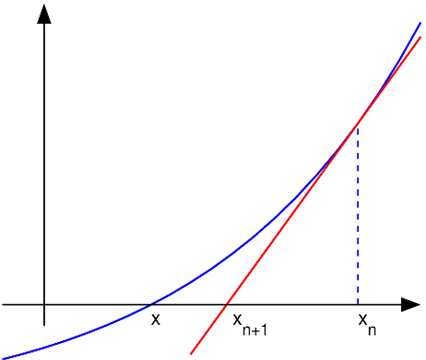

En dérivant le résidu, on trouve :

$$ \overbrace{\langle h^*, \partial_h [\mu(h_k) h_k] \underbrace{(h_{k+1} - h_k)}_{\Delta h_k} \rangle}^{\text{dérivée du résidu}} + \underbrace{\langle h^*, \mu(h_k) h_k \rangle - l_k(h^*)}_{\text{résidu}} = 0 $$

Avec 

$$\partial_h [\mu(h_k) h_k] = I_d \mu(h_k) + h_k \otimes \partial_|h| \mu . \mathrm{d}_\phi |h|$$

Après avoir résolu cette équation, on trouve :

$$ h_{k+1} = h_k + \Delta h_k $$

(On peut éventuellementmettre un coefficient d'amortissement)

In [ ]:
PHI = 1;


def solvePb(rho):
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    
    K1 = BilinearForm(fespace_H1, symmetric=True)
    K1 +=  grad(psi)*rho2mu(rho,h2mu(sqrt(1e-12+grad(phi)*grad(phi))))*grad(phi)*dx
    K2 = BilinearForm(fespace_H1, symmetric=True)
    K2 +=  grad(psi)*rho2mu(rho,h2mu(sqrt(1e-12+grad(phi)*grad(phi))))*grad(phi)*dx

    K1 += psi*PHI*ds(definedon=mesh.Boundaries("bottom"))
    K1 += -psi*PHI*ds(definedon=mesh.Boundaries("up"))

    K2 += psi*PHI*ds(definedon=mesh.Boundaries("left"))
    K2 += -psi*PHI*ds(definedon=mesh.Boundaries("right"))
    
    phi1 = GridFunction(fespace_H1)
    phi2 = GridFunction(fespace_H1)
    Newton(K1,phi1, freedofs = fespace_H1.FreeDofs() ,printing=False)
    Newton(K2,phi2, freedofs = fespace_H1.FreeDofs() ,printing=False)
    
    return(phi1, phi2)
    


In [ ]:
phi1, phi2 = solvePb(rho)

In [ ]:
Draw (grad(phi1), mesh,vectors = { "grid_size":20});
Draw (grad(phi2), mesh,vectors = { "grid_size":20});

In [ ]:
Draw (phi1, mesh);
Draw (phi2, mesh)

## 3) Optimisation



In [ ]:
def objective(phi1,phi2,rho):
    mu1 = rho2mu(rho,h2mu(sqrt(1e-12+grad(phi1)*grad(phi1))))
    mu2 = rho2mu(rho,h2mu(sqrt(1e-12+grad(phi2)*grad(phi2))))
    return(Integrate(grad(phi1)*mu1* grad(phi1) -  grad(phi2)*mu2* grad(phi2), mesh))


def h2dmudh(h):
    return - mu0*(5*hsat**2*((20*h)**2)-hsat**2)/((((20*h)**2)+hsat**2)**2)

def solveAdjoint(rho,phi1,phi2):
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    mu = rho2mu(rho,h2mu(sqrt(1e-12+grad(phi)*grad(phi))))
    dK1 = BilinearForm(fespace_H1, symmetric=True)
    dK1 +=  grad(psi)*mu*grad(phi)*dx
    dK2 = BilinearForm(fespace_H1, symmetric=True)
    dK2 +=  grad(psi)*mu*grad(phi)*dx
    dK1.AssembleLinearization(phi1.vec)
    dK2.AssembleLinearization(phi2.vec)
    
    mu1 = rho2mu(rho,h2mu(sqrt(1e-12+grad(phi1)*grad(phi1))))
    dmu1 = h2dmudh(sqrt(1e-12+grad(phi1)*grad(phi1)))*rho
    dJ1 = LinearForm(fespace_H1)
    dJ1 +=  - dmu1*InnerProduct(grad(phi1),OuterProduct(grad(phi1),grad(phi1))*grad(psi))/sqrt(1e-12+grad(phi1)*grad(phi1))*dx
    dJ1 += - 2*mu1*grad(psi)*grad(phi1)*dx 
    
    mu2 = rho2mu(rho,h2mu(sqrt(1e-12+grad(phi2)*grad(phi2))))
    dmu2 = h2dmudh(sqrt(1e-12+grad(phi2)*grad(phi2)))*rho
    dJ2 = LinearForm(fespace_H1)
    dJ2 += dmu2*InnerProduct(grad(phi2),OuterProduct(grad(phi2),grad(phi2))*grad(psi))/sqrt(1e-12+grad(phi2)*grad(phi2))*dx
    dJ2 += 2*mu2*grad(psi)*grad(phi2)*dx 
    

    dJ1.Assemble()
    dJ2.Assemble()
    
    lb1 = GridFunction(fespace_H1)
    lb2 = GridFunction(fespace_H1)
    
    lb1.vec.data = (dK1.mat.Inverse(fespace_H1.FreeDofs(), inverse="sparsecholesky").T * dJ1.vec)
    lb2.vec.data = (dK2.mat.Inverse(fespace_H1.FreeDofs(), inverse="sparsecholesky").T * dJ2.vec)
    
    
    return lb1,lb2

In [ ]:
print(objective(phi1,phi2,rho))

In [ ]:
lb1,lb2 = solveAdjoint(rho,phi1,phi2)
Draw(lb1, mesh)
Draw(lb2, mesh)

In [ ]:
def gradient(rho,phi1,phi2,lb1,lb2):
    mu1 = rho2mu(rho,h2mu(sqrt(1e-12+grad(phi1)*grad(phi1))))
    mu2 = rho2mu(rho,h2mu(sqrt(1e-12+grad(phi2)*grad(phi2))))
    Lag = grad(lb1)*mu1*grad(phi1)*dx
    Lag += grad(lb2)*mu2*grad(phi2)*dx
    Lag += (grad(phi1)*mu1* grad(phi1) -  grad(phi2)*mu2* grad(phi2))*dx
    rho_test = rho.space.TestFunction()
    temp = LinearForm(rho.space)
    temp += Lag.Diff(rho,rho_test)
    temp.Assemble()
    r_temp = GridFunction(rho.space)
    r_temp.vec.data = temp.vec
    return r_temp
Draw(gradient(rho,phi1,phi2,lb1,lb2))

In [ ]:
objFuncList = []
rhoList = []
descentList = []
step_0 = 1
descent = GridFunction(fespace_rho)
flag = False
for i in range(200):
    
    # Calculs état direct, adjoint et direction de descente
    phi1,phi2 = solvePb(rho)
    lb1,lb2 = solveAdjoint(rho,phi1,phi2)
    descent.Set(gradient(rho,phi1,phi2,lb1,lb2))
    #descent.vec[:] = np.sign(descent.vec[:].FV().NumPy()) ça déforme le vecteur non ? 
    filter_01 = ~((rho.vec[:].FV().NumPy()==0)*(descent.vec[:].FV().NumPy()<0)+(rho.vec[:].FV().NumPy()==1)*(descent.vec[:].FV().NumPy()>0))
    descent.vec[:] = filter_01*descent.vec[:].FV().NumPy()
    descent.vec[:] = descent.vec[:].FV().NumPy()/Norm(descent.vec)

    
    
    rhoList.append(copy(rho))
    descentList.append(copy(descent))
    if i == 0 : objFuncList.append(objective(phi1,phi2,rho))
    step = step_0
    if i>0:
        objFuncList.append(np.inf)
        while objFuncList[-1] > objFuncList[-2]:
            rho.Set(rhoList[i] + descentList[i]*step)
            rho.vec[:].FV().NumPy()[rho.vec[:].FV().NumPy()<0]=0
            rho.vec[:].FV().NumPy()[rho.vec[:].FV().NumPy()>1]=1
            phi1,phi2 = solvePb(rho)
            objFuncList[-1] = objective(phi1,phi2,rho)
            step = step/2
            if step < 1e-8 : print('Done') ; flag = True ;break
    if flag == True : break
    print(f'{objFuncList[-1]} - step : {step}')
    if np.isnan(np.sum(rho.vec[:].FV().NumPy())):
        print('Something is wrong')
        break


In [ ]:
Draw(rho,mesh)